<xarray.Dataset> Size: 28GB
Dimensions:    (depth: 50, latitude: 601, time: 12, longitude: 2401)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 2kB -25.0 -24.92 -24.83 ... 24.83 24.92 25.0
  * time       (time) datetime64[ns] 96B 1993-01-01 1993-02-01 ... 1993-12-01
  * longitude  (longitude) float32 10kB 95.0 95.08 95.17 ... 294.8 294.9 295.0
Data variables:
    so         (time, depth, latitude, longitude) float64 7GB ...
    thetao     (time, depth, latitude, longitude) float64 7GB ...
    vo         (time, depth, latitude, longitude) float64 7GB ...
    zos        (time, latitude, longitude) float64 139MB ...
    uo         (time, depth, latitude, longitude) float64 7GB ...
    bottomT    (time, latitude, longitude) float64 139MB ...
Attributes:
    credit:                    E.U. Copernicus Marine Service Information (CM...
    references:                http://marine.copernicus.eu
    Conventions:               CF-1.6
    contact:                   servicedesk.cmems@mercator-ocean.eu
    institution:               Mercator Ocean
    title:                     Monthly climatology fields for product GLOBAL_...
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    source:                    MERCATOR GLORYS12V1
    copernicusmarine_version:  2.2.2

(12, 49, 193, 61)


<xarray.Dataset> Size: 14GB
Dimensions:      (Zmd000035: 35, Xp1: 721, Y: 192, X: 720, Yp1: 193, T: 120,
                  Zld000035: 35)
Coordinates:
  * Xp1          (Xp1) float64 6kB 111.9 112.1 112.4 112.6 ... 291.4 291.6 291.9
  * Y            (Y) float64 2kB -23.0 -22.75 -22.5 -22.25 ... 24.25 24.5 24.75
  * X            (X) float64 6kB 112.0 112.2 112.5 112.8 ... 291.2 291.5 291.8
  * Yp1          (Yp1) float64 2kB -23.12 -22.88 -22.62 ... 24.38 24.62 24.88
  * T            (T) datetime64[ns] 960B 1940-02-15T10:30:00 ... 1950-01-15T1...
Dimensions without coordinates: Zmd000035, Zld000035
Data variables:
    diag_levels  (Zmd000035) float64 280B ...
    iter         (T) int32 480B ...
    UVEL         (T, Zmd000035, Y, Xp1) float32 2GB ...
    VVEL         (T, Zmd000035, Yp1, X) float32 2GB ...
    WVEL         (T, Zld000035, Y, X) float32 2GB ...
    THETA        (T, Zmd000035, Y, X) float32 2GB ...
    SALT         (T, Zmd000035, Y, X) float32 2GB ...
    PHIHYD       (T, Zmd000035, Y, X) float32 2GB ...
Attributes: (12/18)
    MITgcm_version:  checkpoint69e
    build_user:      zhanghang
    build_host:      login1
    build_date:      Fri Dec 12 14:41:48 CST 2025
    MITgcm_URL:      http://mitgcm.org
    MITgcm_tag_id:   
    ...              ...
    nSy:             1
    nPx:             16
    nPy:             4
    Nx:              720
    Ny:              192
    Nr:              35

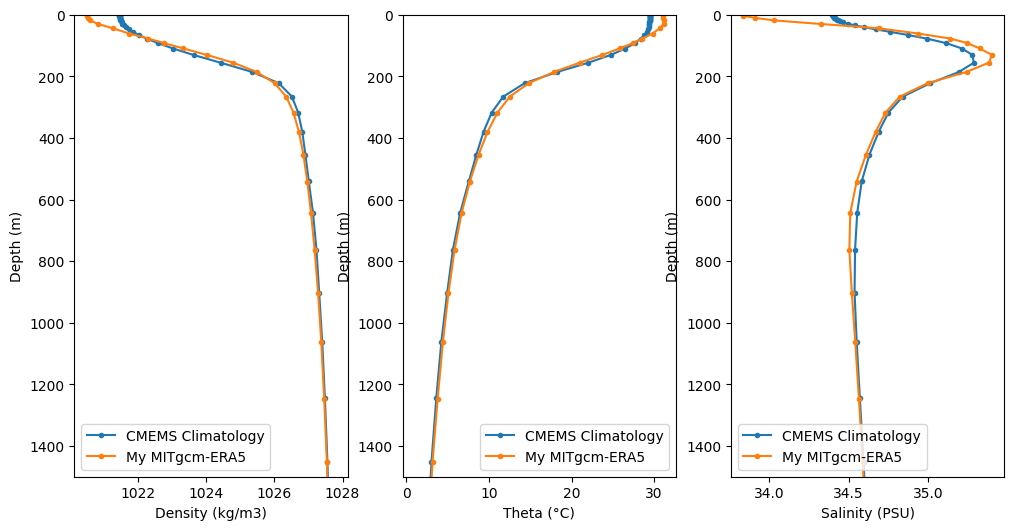

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
path = '../../data/'
pclim = path+'cmems_climatology_mon.nc'
path = '../output/251212/'
pgrid = path+'grid.nc'
pdync = path+'dync.nc'
tl,zl,yl,xl = slice(None),slice(-1),slice(-8,8),slice(155,160)

with xr.open_dataset(pclim) as clim:
    display(clim)
    t = clim['thetao'][tl,zl].loc[:,:,yl,xl]
    s = clim['so'][tl,zl].loc[:,:,yl,xl]
    print(t.shape)
    to = t.mean(['time','latitude','longitude']).values
    so = s.mean(['time','latitude','longitude']).values
    dep = clim['depth'][zl].values
    dr = np.zeros(dep.shape)
    lev = 0
    for i in range(dep.size):
        dr[i] = 2*(dep[i]-lev)
        lev += dr[i]
pdo = sw.dens0(so,to)

with xr.open_dataset(pgrid) as grid:
    z = -grid['Z'].values
    dz = grid['Zl'].values-grid['Zu'].values
i = 29
tl,zl = slice(-12,None),slice(None)
with xr.open_dataset(pdync) as dync:
    display(dync)
    t = dync['THETA'][tl].loc[:,zl,yl,xl]
    s = dync['SALT'][tl].loc[:,zl,yl,xl]
    t,s = t.where(t), s.where(s)
    t = t.mean(['T','Y','X']).values
    s = s.mean(['T','Y','X']).values
    u = dync['UVEL'][tl].loc[:,zl,yl,xl]
    x = u[u.dims[3]].values
    y = u[u.dims[2]].values
pd = sw.dens0(s,t)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(pdo,dep,marker='.',label='CMEMS Climatology')
plt.plot(pd,z,marker='.',label='My MITgcm-ERA5')
plt.xlabel('Density (kg/m3)')
plt.ylabel('Depth (m)')
plt.ylim(1500,0)
plt.legend()
plt.subplot(132)
plt.plot(to,dep,marker='.',label='CMEMS Climatology')
plt.plot(t,z,marker='.',label='My MITgcm-ERA5')
plt.xlabel('Theta (°C)')
plt.ylabel('Depth (m)')
plt.ylim(1500,0)
plt.legend()
plt.subplot(133)
plt.plot(so,dep,marker='.',label='CMEMS Climatology')
plt.plot(s,z,marker='.',label='My MITgcm-ERA5')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.ylim(1500,0)
plt.legend()
plt.savefig(path+'profile.png',dpi=300)

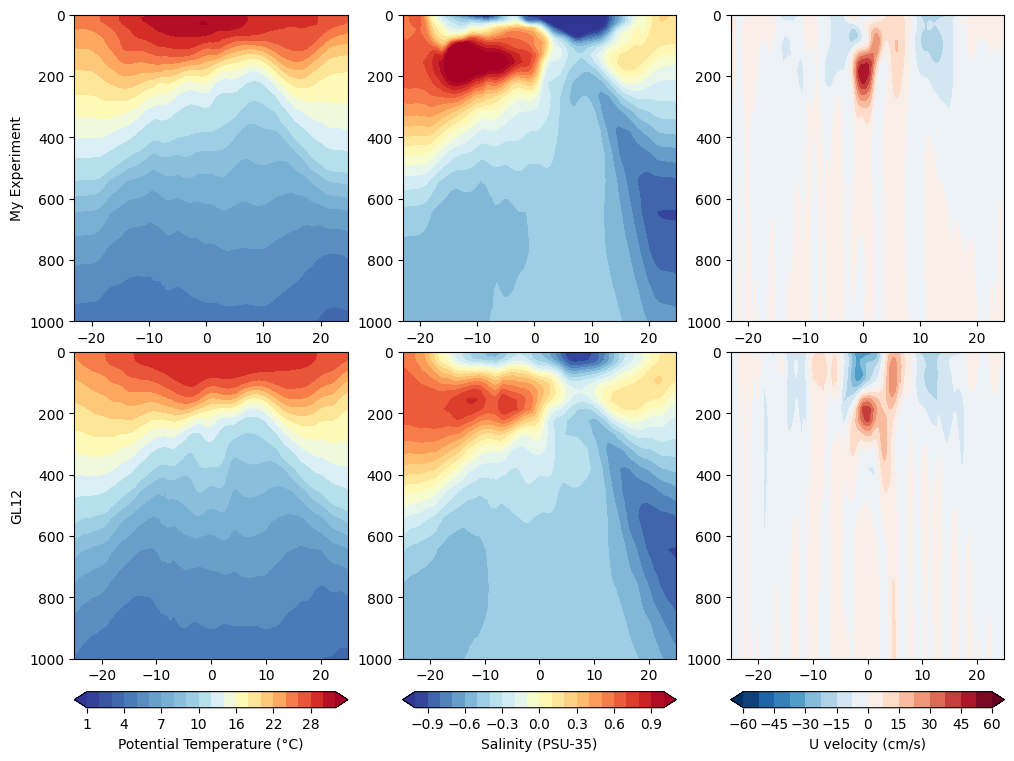

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
from dymodes import dymodes
path = '../../data/'
pclim = path+'cmems_climatology_mon.nc'
tl,zl,yl,xl = slice(None),slice(-1),slice(None,None),slice(155,160)
with xr.open_dataset(pclim) as clim:
    to = clim['thetao'][tl,zl].loc[:,:,yl,xl]
    so = clim['so'][tl,zl].loc[:,:,yl,xl]
    uo = clim['uo'][tl,zl].loc[:,:,yl,xl]
    xo = uo[uo.dims[3]].values
    yo = uo[uo.dims[2]].values
    zo = uo[uo.dims[1]].values
    to = to.mean(['time','longitude']).values
    so = so.mean(['time','longitude']).values
    uo = uo.mean(['time','longitude']).values

path = '../output/251212/'
tl,zl = slice(-12,None),slice(None)
with xr.open_dataset(path+'grid.nc') as grid:
    z = -grid['Z'].values
with xr.open_dataset(path+'dync.nc') as dync:
    t = dync['THETA'][tl].loc[:,zl,yl,xl]
    s = dync['SALT'][tl].loc[:,zl,yl,xl]
    u = dync['UVEL'][tl].loc[:,zl,yl,xl]
    x = u[u.dims[3]].values
    y = u[u.dims[2]].values
    t,s = t.where(t), s.where(s)
    u = u.where(u)
    t = t.mean(['T','X']).values
    s = s.mean(['T','X']).values
    u = u.mean(['T','Xp1']).values
ylim = [1000,0]
fg = plt.figure(figsize=(12,9))
gs = fg.add_gridspec(2,1,height_ratios=[2,0.05],hspace=0.1)
gsf = gs[0].subgridspec(2,3,hspace=0.1)
gsc = gs[1].subgridspec(1,3)

levels = np.concatenate((np.arange(1,10,1),np.arange(10,33,2)))
plt.subplot(gsf[0,0])
plt.contourf(y,z,t,levels,cmap='RdYlBu_r',extend='both')
plt.ylabel('My Experiment')
plt.ylim(ylim)
plt.subplot(gsf[1,0])
im = plt.contourf(yo,zo,to,levels,cmap='RdYlBu_r',extend='both')
plt.ylim(ylim)
plt.ylabel('GL12')
plt.colorbar(im,cax=plt.subplot(gsc[0]),orientation='horizontal',label='Potential Temperature (°C)')

levels = np.linspace(-1,1,21)
plt.subplot(gsf[0,1])
plt.contourf(y,z,s-35,levels,cmap='RdYlBu_r',extend='both')
plt.ylim(ylim)
plt.subplot(gsf[1,1])
im = plt.contourf(yo,zo,so-35,levels,cmap='RdYlBu_r',extend='both')
plt.ylim(ylim)
plt.colorbar(im,cax=plt.subplot(gsc[1]),orientation='horizontal',label='Salinity (PSU-35)')

levels = 60*np.linspace(-1,1,17)
plt.subplot(gsf[0,2])
plt.contourf(y,z,u*100,levels,cmap='RdBu_r',extend='both')
plt.ylim(ylim)
plt.subplot(gsf[1,2])
im = plt.contourf(yo,zo,uo*100,levels,cmap='RdBu_r',extend='both')
plt.ylim(ylim)
plt.colorbar(im,cax=plt.subplot(gsc[2]),orientation='horizontal',label='U velocity (cm/s)')
plt.savefig(path+'section.png',dpi=300)